File : Project_Vehicles

Name : Avinash Alapati 

Date : 03/05/2021

Course : DSC-540 - Data Preparation

Assignment :
Now that you have cleaned and transformed your 3 datasets, you need to load them into a database. You can choose what kind of database (SQLLite or MySQL, Postgre SQL are all free options). You will want to load each dataset into SQL Lite as an individual table and then you must join the datasets together in Python into 1 dataset.

Once all the data is merged together in your database, create 5 visualizations that demonstrate the data you have cleansed. You should have at least 2 visualizations that have data from more than one source (meaning, if you have 3 tables, you must have visualizations that span across 2 of the tables – you are also welcome to use your consolidated dataset that you created in the previous step, if you do that, you have met this requirement).


In [66]:
# Adding all the imports
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import json
import csv

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pylab
import pandas as pd
import numpy as np
import sqlite3
from sqlite3 import Error
import os


In [67]:
# Database & HTTP related functions

def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

    return conn

def add_data_table(table_name, data_df, conn):
    """ Adds data to the specified table
    :param table_name: Name of the table
    :param data_df: data to be added in data_frame
    :param conn: database connection
    """
    #Saving data to the database
    data_df.to_sql(table_name, con=conn, if_exists='replace', index=False)
    conn.commit()


In [68]:
# In this step we will be reading the vehicle year, make and model from the back4app Api

state_codes = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

def fetch_request(url, headers):
    """
    Function to use requests.get on provided url with retry and delay between retries.
    :param url: Web site or the endpoint to call
    :param headers: headers to pass along with the request
    :return: returns the response
    """
    s = requests.Session()
    retries = Retry(total=1,
                    backoff_factor=0.3,
                    status_forcelist=[500, 502, 503, 504])
    s.mount('http://', HTTPAdapter(max_retries=retries))
    s.mount('https://', HTTPAdapter(max_retries=retries))
    try :
        res = s.get(url, headers=headers)
        if res.status_code == requests.codes['ok']:
            return res
    except Exception as exe:
        print(f"Unable to load the url {exe}")
        return None

# Fetches the data from back4app.com rest api's
def fetch_vehicles_back4app(url, headers):
    """ Returns the vehicle types from back4app url
    :param url: Web site or the endpoint to call
    :param headers: headers to pass along with the request
    :return: returns the vehicle type parameters
    """
    response = fetch_request(url, headers).json()

    # Step 1 - Converting the data from json to dataframe format
    vehicle_ymm_df = pd.json_normalize(response['results'])

    # Step 2 - Replacing the headers
    vehicle_ymm_df.rename(columns={'createdAt': 'created_on', 'updatedAt': 'updated_on'}, inplace=True)

    # Step 3 - Removing the unneccessary columns - objectId
    vehicle_ymm_df = vehicle_ymm_df[['Year', 'Make', 'Model', 'Category', 'created_on', 'updated_on']]

    # Step 4 - Finding the duplicates
    duplicate_count = vehicle_ymm_df.isnull().sum()
    #print(f'The total duplicates found on the YMM are \n{vehicle_ymm_df.isnull().sum()}')

    return vehicle_ymm_df


# DataSet #2 - Download and extract to local folder Edmunds from https://www.kaggle.com/jpayne/852k-used-car-listings
def fetch_emdus_car_reviews():
    """ Returns the vehicle reviews for the edmunds folder. Folder contains data by car type
    :return: returns the vehicle reviews
    """
    
    directory = 'Edmunds'
    final_reviews_df = pd.DataFrame(columns=['Year', 'Make', 'Model', 'Review_Date', 'Author_Name', 'Review_Title', 'Review', 'Rating'])

    for file_name in os.listdir(directory):
        print(f'Processing the {file_name}')
        reviews_df = pd.read_csv(directory + '/' + file_name, sep=',', encoding="utf-8", quoting=csv.QUOTE_ALL)

        duplicateRowsDF = reviews_df[reviews_df.duplicated(keep='last')]
        reviews_df.drop_duplicates(keep='last',inplace=True)

        # Cleaning the data for craiglist used car listings

        #Step 2 - Fixing the review date, removing the starting on and PDT and PST time frames
        reviews_df['Review_Date'] = reviews_df['Review_Date'].str.replace('on ','')
        reviews_df['Review_Date'] = reviews_df['Review_Date'].str.replace('\(PDT\)','')
        reviews_df['Review_Date'] = reviews_df['Review_Date'].str.replace('\(PST\)','')

        # Step 3 - Breaking the vehicle title into year, make and model.
        reviews_df["Year"] = reviews_df["Vehicle_Title"].str.split(" ").str[0]
        reviews_df["Make"] = reviews_df["Vehicle_Title"].str.split(" ").str[1]
        reviews_df["Model"] = reviews_df["Vehicle_Title"].str.split(" ").str[2:]
        reviews_df['Model'] = [' '.join(map(str, l)) for l in reviews_df['Model']]

        # Step 4 - Removing the index column, reordering the columns for clarity purposes.
        reviews_df = reviews_df[['Year', 'Make', 'Model', 'Review_Date', 'Author_Name', 'Review_Title', 'Review', 'Rating']]
        #final_reviews_df.append(reviews_df, ignore_index = True)
        results = [final_reviews_df, reviews_df]
        final_reviews_df = pd.concat(results)
        
    return final_reviews_df


def fetch_truecar_vehicle_sales():
    """ Returns the vehicle sales records from truecar data
    :return: returns the vehicle sales data
    """
    true_car_listings_df = pd.read_csv("true_car_listings.csv")
    #true_car_listings_df.head()
    
    # Step 1 - Checking for nan & duplicates
    duplicate_count = true_car_listings_df.isnull().sum()
    #print(f'Total number of rows with NaN\n{true_car_listings_df.isnull().sum()}')

    duplicateRowsDF = true_car_listings_df[true_car_listings_df.duplicated(keep='last')]
    #print(f'Total duplicate rows : {len(duplicateRowsDF)}')

    #true_car_listings_df = true_car_listings_df[true_car_listings_df.duplicated(['Year', 'Make', 'Model', 'Price', 'Mileage', 'Vin', 'State'], keep="last")]
    true_car_listings_df.drop_duplicates(keep='last',inplace=True)
    #print(f'Total rows in the data frame are : {len(true_car_listings_df)}')

    # Step 2 - Replacing the headers
    true_car_listings_df.rename(columns={'State': 'StateCode'}, inplace=True)

    # Step 3 - Rearranging the column to more readable format
    true_car_listings_df = true_car_listings_df[['Year', 'Make', 'Model', 'Price', 'Mileage', 'Vin', 'StateCode']]

    # Step 4 - VIN Should be for 17 characters, StateCode should be valid
    true_car_listings_df = true_car_listings_df[true_car_listings_df['Vin'].apply(lambda x: len(x) == 17)]
    #print(f'Total rows after removing the data which vin is not 17 lengths : {len(true_car_listings_df)}')

    true_car_listings_df.loc[true_car_listings_df['StateCode'].isin(state_codes)]
    #print(f'Total rows after removing the data which state codes are not valid : {len(true_car_listings_df)}')
    
    return true_car_listings_df


def fetch_craiglist_vehicle_sales():
    craigslist_df = pd.read_csv("vehicles.csv")
    #craigslist_df.head()

    #print(f'Total rows in the data frame are : {len(craigslist_df)}')

    # Step 1 - Checking for nan & duplicates
    duplicate_count = craigslist_df.isnull().sum()
    #print(f'Total number of rows with NaN\n{craigslist_df.isnull().sum()}')

    duplicateRowsDF = craigslist_df[craigslist_df.duplicated(keep='last')]
    craigslist_df.drop_duplicates(keep='last',inplace=True)
    #print(f'Total duplicate rows : {len(duplicateRowsDF)}')
    #print(f'Total rows in the data frame are : {len(craigslist_df)}')

    # Step 2 - Removing the index column, reordering & renaming the columns for clarity purposes.
    craigslist_df = craigslist_df[['year', 'manufacturer','model', 'price', 'odometer','VIN','state']]
    craigslist_df.rename(columns={'year': 'Year', 'manufacturer': 'Make', 'model': 'Model', 'state': 'StateCode'}, inplace=True)
    craigslist_df.rename(columns={'price': 'Price', 'odometer': 'Mileage'}, inplace=True)
    craigslist_df.rename(columns={'VIN': 'Vin'}, inplace=True)

    # Step 3 - VIN Should be for 17 characters, StateCode should be valid
    craigslist_df = craigslist_df[craigslist_df['Vin'].notna()]
    craigslist_df = craigslist_df[craigslist_df['Vin'].apply(lambda x: len(x) == 17)]
    #print(f'Total rows after removing the data which vin is not 17 lengths : {len(craigslist_df)}')

    # Step 4 - Converting the state code to upper case
    craigslist_df['StateCode'] = craigslist_df['StateCode'].apply(lambda x: x.upper())
    craigslist_df.loc[craigslist_df['StateCode'].isin(state_codes)]
    #print(f'Total rows after removing the data which state codes are not valid : {len(craigslist_df)}')

    return craigslist_df

In [69]:
# Fetch Vehicle Data
url = 'https://parseapi.back4app.com/classes/Car_Model_List?limit=100000&order=Year'
headers = {'X-Parse-Application-Id' : 'hlhoNKjOvEhqzcVAJ1lxjicJLZNVv36GdbboZj3Z', 'X-Parse-Master-Key' : 'SNMJJF0CZZhTPhLDIqGhTlUNV9r60M2Z5spyWfXW'}

database_name = 'dsc-540.db'
conn = create_connection(database_name)

# back4app vehicle types
print(f'\nFetching the vehicle types from back4app\n'+'-'*70)
vehicle_ymm_df = fetch_vehicles_back4app(url, headers)
add_data_table('back4app_vehicle_types', vehicle_ymm_df, conn)

#true_car vehicle sales data
print(f'\nFetching the vehicle sales data from truecar\n'+'-'*70)
true_car_listings_df = fetch_truecar_vehicle_sales()
add_data_table('truecar_vehicles', true_car_listings_df, conn)


# Craiglist vehicle sales data
print(f'\nFetching the vehicle sales data from criaglist\n'+'-'*70)
craiglist_df = fetch_craiglist_vehicle_sales()
add_data_table('craiglist_vehicles', craiglist_df, conn)


# Emdus car review
print(f'\nFetching the vehicle reviews data from emdus\n'+'-'*70)
emdus_car_reviews = fetch_emdus_car_reviews()
add_data_table('car_reviews_vehicles', emdus_car_reviews, conn)




Fetching the vehicle types from back4app
----------------------------------------------------------------------

Fetching the vehicle sales data from truecar
----------------------------------------------------------------------

Fetching the vehicle sales data from criaglist
----------------------------------------------------------------------

Fetching the vehicle reviews data from emdus
----------------------------------------------------------------------
Processing the Scraped_Car_Review_genesis.csv
Processing the Scrapped_Car_Reviews_AlfaRomeo.csv
Processing the Scraped_Car_Review_fiat.csv
Processing the Scrapped_Car_Review_Bugatti.csv
Processing the Scraped_Car_Review_tesla.csv
Processing the Scraped_Car_Review_mclaren.csv
Processing the Scraped_Car_Review_ram.csv


In [70]:
#Merging the vehicle sales data
print(f'\nThe length of the craiglist_df is {len(craiglist_df)}\n'+'-'*70)
print(f'\nThe length of the true_car_listings_df is {len(true_car_listings_df)}\n'+'-'*70)
results = [true_car_listings_df, craiglist_df]
final_sales_data = pd.concat(results)

print(f'\nThe length of the final_sales_data is {len(final_sales_data)}\n'+'-'*70)
#craiglist_df.head()
#true_car_listings_df.head()
final_sales_data.head()




The length of the craiglist_df is 17592
----------------------------------------------------------------------

The length of the true_car_listings_df is 852091
----------------------------------------------------------------------

The length of the final_sales_data is 869683
----------------------------------------------------------------------


,Year,Make,Model,Price,Mileage,Vin,StateCode
0,2014.0,Acura,ILX6-Speed,8995,35725.0,19VDE2E53EE000083,TX
1,2013.0,Acura,ILX5-Speed,10888,19606.0,19VDE1F52DE012636,NY
2,2013.0,Acura,ILX6-Speed,8995,48851.0,19VDE2E52DE000025,TX
3,2014.0,Acura,ILX5-Speed,10999,39922.0,19VDE1F71EE003817,CO
4,2016.0,Acura,ILXAutomatic,14799,22142.0,19UDE2F32GA001284,UT


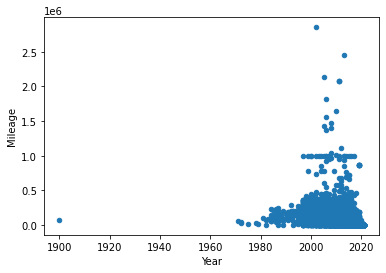

In [71]:
# Ploting the scattered chart based on year and mileage
final_sales_data.plot(x='Year', y='Mileage', kind = 'scatter')

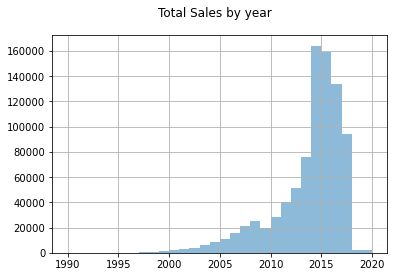

In [72]:
# Ploting the histogram chart for year
final_sales_data["Year"].hist(bins=30, alpha=0.5, range=[1990, 2020])
plt.suptitle("Total Sales by year")
plt.show()

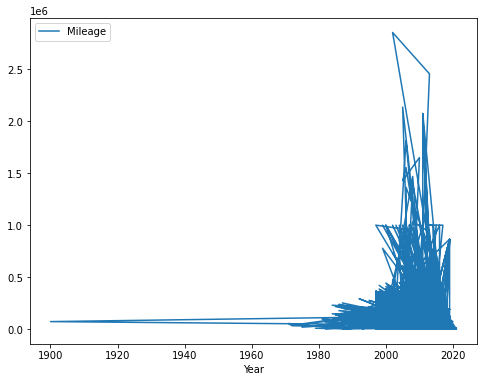

In [73]:
# Ploting the line chart for year and mileage
final_sales_data.plot.line(x='Year', y='Mileage', figsize=(8,6))
plt.show()

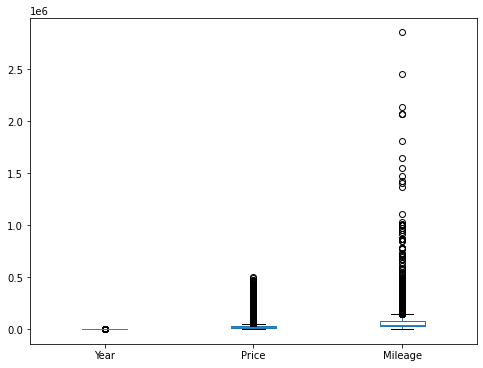

In [74]:
# Ploting the Boxplot chart
final_sales_data.plot.box(figsize=(8,6))
plt.show()

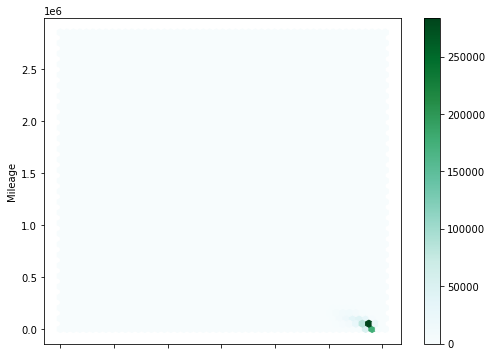

In [75]:
# Ploting the Hexagonal Chart based on  year and mileage
final_sales_data.plot.hexbin(x='Year', y='Mileage',gridsize=50, figsize=(8,6))
plt.show()

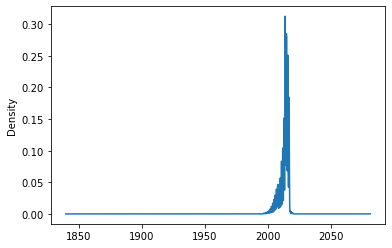

In [76]:
# Ploting the Kernel Density Chart per year
final_sales_data["Year"].plot.kde()
plt.show()

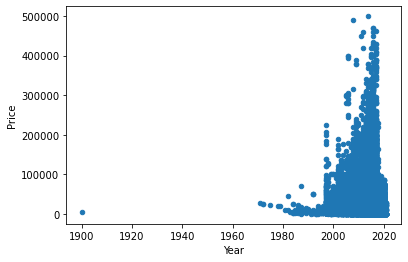

In [77]:
# Ploting the scattered chart based on year and Total price collective of all cars
final_sales_data.plot(x='Year', y='Price', kind = 'scatter')

The Above plot based on price and year states that the purchase and cost of cars have gone significantly after 2000 year the total cost of cars owned by all segment of people spiked between  2010 and 2015 and slowed down from 2015 to 2020. The conclusion would be purchase of cars would have gone down after 2015 due to several factors which could be recent covoid which impacted purchase capability of individuals. 

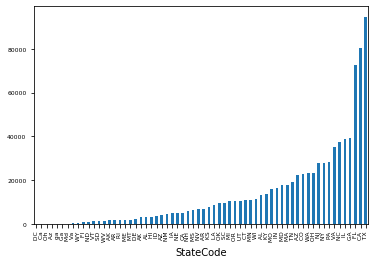

In [78]:
# Ploting the bar chart based on total sale of cars from respective US states.
car_totals = final_sales_data.groupby('StateCode')['Make'].count().sort_values()
car_totals.plot(kind="bar", fontsize=6)

The Above plot in bars explains different states from lowest to highest collection of cars of all makes, We can confirm that Texas, California and Florida are the states with highest collection of cars and DC having lowest collection of cars compared to other states.

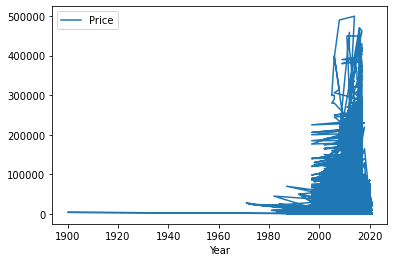

In [79]:
# Ploting the line chart for year and Total Price
final_sales_data.plot.line(x='Year', y='Price', figsize=(6,4))
plt.show()

Line Chart presentation of Year and Total Price of cars in respective years. Total cost of cars owned by all customers have gone up over respective years.